In [1]:
# Input info
se_cells_meta_f = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/clonal_shifts/clones/"

clone_col = "name"
atac_col = "cluster_labels"

# config
N_DONORS = 2
input_cond = "Input"
condition = "inputOnly" # noInput

# params
min_clone_size = 10
p_thresh = 0.1 

n_cpus = 12

n_shuffle=10000
#conds_sep = False



In [2]:
import pandas as pd
import numpy as np
from os.path import join, exists
import os
from tqdm.notebook import tqdm

from scipy.stats import hypergeom, fisher_exact
from statsmodels.stats import multitest 

import seaborn as sns
import matplotlib.pyplot as plt

from src import clonal_shifts as cs
from icecream import ic

### Setup outdirs

In [3]:
all_dir = join(outdir,"combDonors")
sep_dir = join(outdir,"sepDonors")


if not exists(all_dir):
    os.mkdir(all_dir)

donor_out = {}
for d in np.arange(N_DONORS):
    donor_out[d] = join(sep_dir, f"donor{d}")
    if not exists(donor_out[d]):
        os.mkdir(donor_out[d])
        
    
# sim_all_dir = join(all_dir, "shuffle")
# sim_sep_dir = join(sep_dir, "shuffle")
# if not exists(sep_dir):
#     os.mkdir(sep_dir)
# if not exists(sim_all_dir):
#     os.mkdir(sim_all_dir)


In [4]:
%load_ext autoreload
%autoreload 2

## Load barcodes, and add donor id for the labels

## Load cells_meta

In [5]:
cells_meta = pd.read_csv(se_cells_meta_f, sep="\t")
cells_meta = cells_meta.loc[~(cells_meta["name"]=="None")]

if not "cluster_labels" in cells_meta.columns.values:
    cells_meta["cluster_labels"] = cells_meta["seurat_clusters"]
cells_meta

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Control_AAACGAAAGAATCAGT-1,Control,1972,1972,6432,1259,31,19,266,1066,3791,...,6,2211,1942,AAACGAAAGAATCAGT-1_Control,Control_AAACGAAAGAATCAGT-1,4,1,Control,1_4,eosonophil
Control_AAACGAAAGCATACCT-1,Control,2674,2674,11858,1937,51,34,549,3102,6185,...,7,3311,2750,AAACGAAAGCATACCT-1_Control,Control_AAACGAAAGCATACCT-1,30,1,Control,1_30,MPP/CMP/GMP C
Control_AAACGAAAGCGAGAAA-1,Control,1939,1939,7365,1097,25,27,275,2184,3757,...,7,2112,1838,AAACGAAAGCGAGAAA-1_Control,Control_AAACGAAAGCGAGAAA-1,27,0,Control,0_27,MPP/CMP/GMP C
Control_AAACGAAAGTACAGAT-1,Control,862,862,4095,861,16,16,230,771,2201,...,4,1441,1317,AAACGAAAGTACAGAT-1_Control,Control_AAACGAAAGTACAGAT-1,4,0,Control,0_4,erythroid
Control_AAACGAAAGTACAGTA-1,Control,1775,1775,8088,1091,27,27,369,2157,4417,...,6,2385,2085,AAACGAAAGTACAGTA-1_Control,Control_AAACGAAAGTACAGTA-1,21,1,Control,1_21,eosonophil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Input_TTTGTGTGTTTCTTAC-1,Input,3585,3585,17067,3257,63,80,461,8097,5109,...,3,3738,2899,TTTGTGTGTTTCTTAC-1_Input,Input_TTTGTGTGTTTCTTAC-1,11,0,Input,0_11,MPP/CMP/GMP B
Input_TTTGTGTTCCTGAAAC-1,Input,4362,4362,30427,8323,84,99,799,12146,8976,...,11,5839,4144,TTTGTGTTCCTGAAAC-1_Input,Input_TTTGTGTTCCTGAAAC-1,7,0,Input,0_7,MEP
Input_TTTGTGTTCGGGAAAC-1,Input,8047,8047,40114,14032,169,160,1561,10102,14090,...,3,9421,5890,TTTGTGTTCGGGAAAC-1_Input,Input_TTTGTGTTCGGGAAAC-1,25,0,Input,0_25,MPP/CMP/GMP B
Input_TTTGTGTTCGGGACAA-1,Input,3303,3303,22721,4421,43,84,546,11692,5935,...,4,4303,3323,TTTGTGTTCGGGACAA-1_Input,Input_TTTGTGTTCGGGACAA-1,6,1,Input,1_6,erythroid


## Map the new group to cells_meta

## Filter for condition

,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,seurat_clusters,nCount_RNA,nFeature_RNA,ID,Row.names,lineage,donor,condition,name,cluster_labels
Input_AAACGAAAGATATGAC-1,Input,2858,2858,29954,4853,67,103,626,19521,4784,...,2,3172,2505,AAACGAAAGATATGAC-1_Input,Input_AAACGAAAGATATGAC-1,23,1,Input,1_23,MPP/CMP/GMP
Input_AAACGAAAGTAATGTG-1,Input,6511,6511,32111,9018,96,122,1319,11232,10324,...,2,7161,4861,AAACGAAAGTAATGTG-1_Input,Input_AAACGAAAGTAATGTG-1,1,1,Input,1_1,MPP/CMP/GMP
Input_AAACGAAAGTAGTCGG-1,Input,7561,7561,37923,12542,147,162,1705,10189,13178,...,3,8960,5447,AAACGAAAGTAGTCGG-1_Input,Input_AAACGAAAGTAGTCGG-1,5,1,Input,1_5,MPP/CMP/GMP B
Input_AAACGAACACATTGCA-1,Input,6920,6920,46206,12553,148,184,1239,16880,15202,...,13,10041,5539,AAACGAACACATTGCA-1_Input,Input_AAACGAACACATTGCA-1,0,1,Input,1_0,CLP
Input_AAACGAACACGCTCAG-1,Input,5875,5875,38973,7584,162,150,973,19691,10413,...,2,7103,4786,AAACGAACACGCTCAG-1_Input,Input_AAACGAACACGCTCAG-1,1,0,Input,0_1,MPP/CMP/GMP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Input_TTTGTGTGTTTCTTAC-1,Input,3585,3585,17067,3257,63,80,461,8097,5109,...,3,3738,2899,TTTGTGTGTTTCTTAC-1_Input,Input_TTTGTGTGTTTCTTAC-1,11,0,Input,0_11,MPP/CMP/GMP B
Input_TTTGTGTTCCTGAAAC-1,Input,4362,4362,30427,8323,84,99,799,12146,8976,...,11,5839,4144,TTTGTGTTCCTGAAAC-1_Input,Input_TTTGTGTTCCTGAAAC-1,7,0,Input,0_7,MEP
Input_TTTGTGTTCGGGAAAC-1,Input,8047,8047,40114,14032,169,160,1561,10102,14090,...,3,9421,5890,TTTGTGTTCGGGAAAC-1_Input,Input_TTTGTGTTCGGGAAAC-1,25,0,Input,0_25,MPP/CMP/GMP B
Input_TTTGTGTTCGGGACAA-1,Input,3303,3303,22721,4421,43,84,546,11692,5935,...,4,4303,3323,TTTGTGTTCGGGACAA-1_Input,Input_TTTGTGTTCGGGACAA-1,6,1,Input,1_6,erythroid


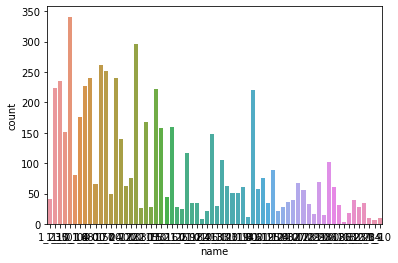

In [6]:
if condition == "inputOnly":
    cells_meta = cells_meta.loc[cells_meta["condition"]==input_cond]
else:
    cells_meta = cells_meta.loc[cells_meta["condition"]!=input_cond]
#sns.countplot(data=cells_meta,x=clone_col)
cells_meta

## construct the clone_groups and atac_cl_groups

## A) Loop through donor and run 

donor 0
['0_0' '0_1' '0_10' '0_11' '0_12' '0_13' '0_14' '0_15' '0_16' '0_17'
 '0_18' '0_19' '0_2' '0_20' '0_21' '0_22' '0_23' '0_24' '0_25' '0_26'
 '0_27' '0_28' '0_29' '0_3' '0_30' '0_31' '0_32' '0_33' '0_4' '0_5' '0_6'
 '0_7' '0_8' '0_9']
['CLP' 'DC' 'MEP' 'MPP/CMP/GMP' 'MPP/CMP/GMP B' 'MPP/CMP/GMP C'
 'MPP/CMP/GMP D' 'eosonophil' 'erythroid' 'macrophage' 'meg/erythroid'
 'monocyte' 'neutrophil' 'neutrophil B']
plotting counts


ic| len(global_min): 10000
ic| len(clone_min): 34
ic| len(clone_min): 34
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic

Number of groups below p-val significance: 52
Number of groups below p-val significance: 0
clone all
axs 9
bh shape (34, 14)
clone min
donor 1
['1_0' '1_1' '1_11' '1_12' '1_13' '1_14' '1_15' '1_16' '1_17' '1_18'
 '1_19' '1_2' '1_20' '1_21' '1_22' '1_23' '1_24' '1_25' '1_26' '1_27'
 '1_28' '1_29' '1_3' '1_30' '1_31' '1_32' '1_4' '1_5' '1_6' '1_7' '1_8'
 '1_9']
['CLP' 'DC' 'MEP' 'MPP/CMP/GMP' 'MPP/CMP/GMP B' 'MPP/CMP/GMP C'
 'MPP/CMP/GMP D' 'eosonophil' 'erythroid' 'macrophage' 'meg/erythroid'
 'monocyte' 'neutrophil' 'neutrophil B']
plotting counts


ic| len(global_min): 10000
ic| len(clone_min): 32
ic| len(clone_min): 32
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic

Number of groups below p-val significance: 43
Number of groups below p-val significance: 1
clone all
axs 8
bh shape (32, 14)
clone min


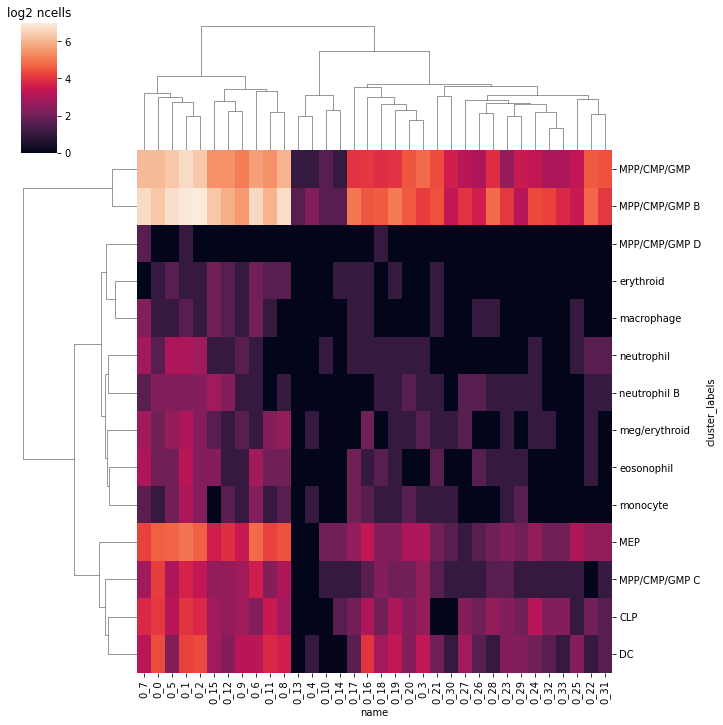

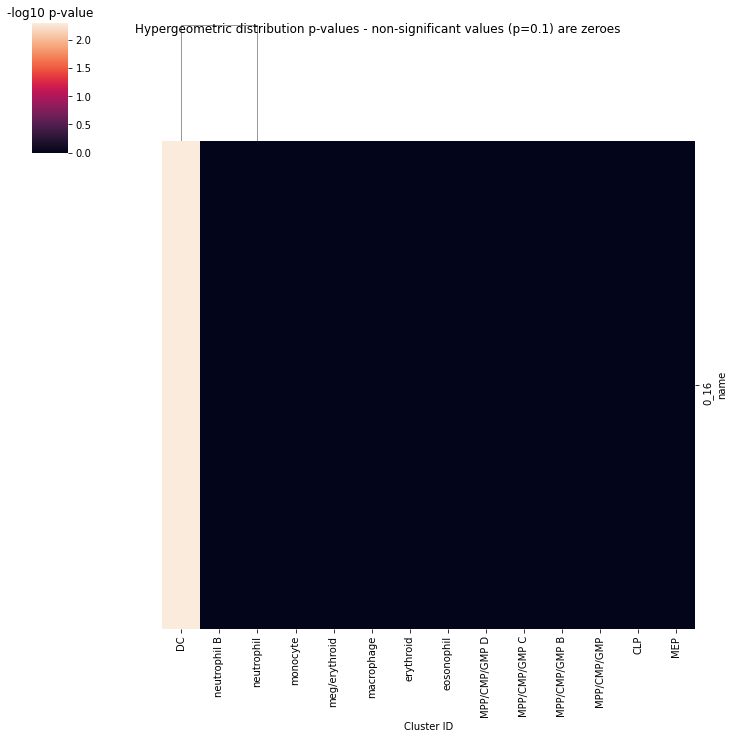

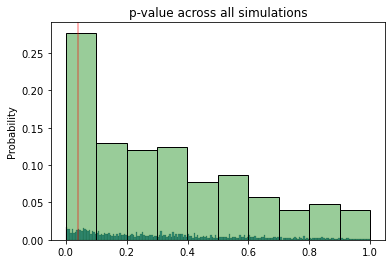

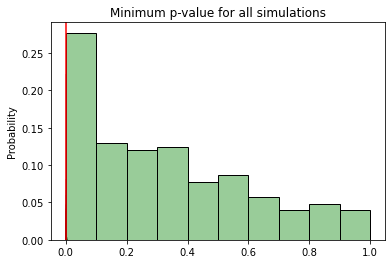

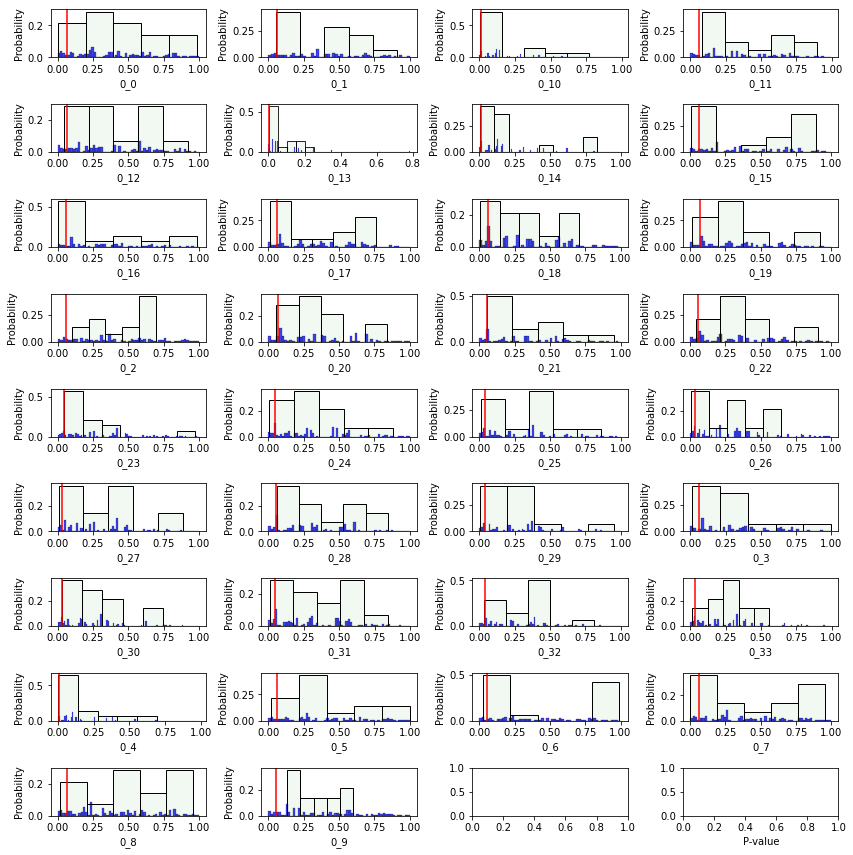

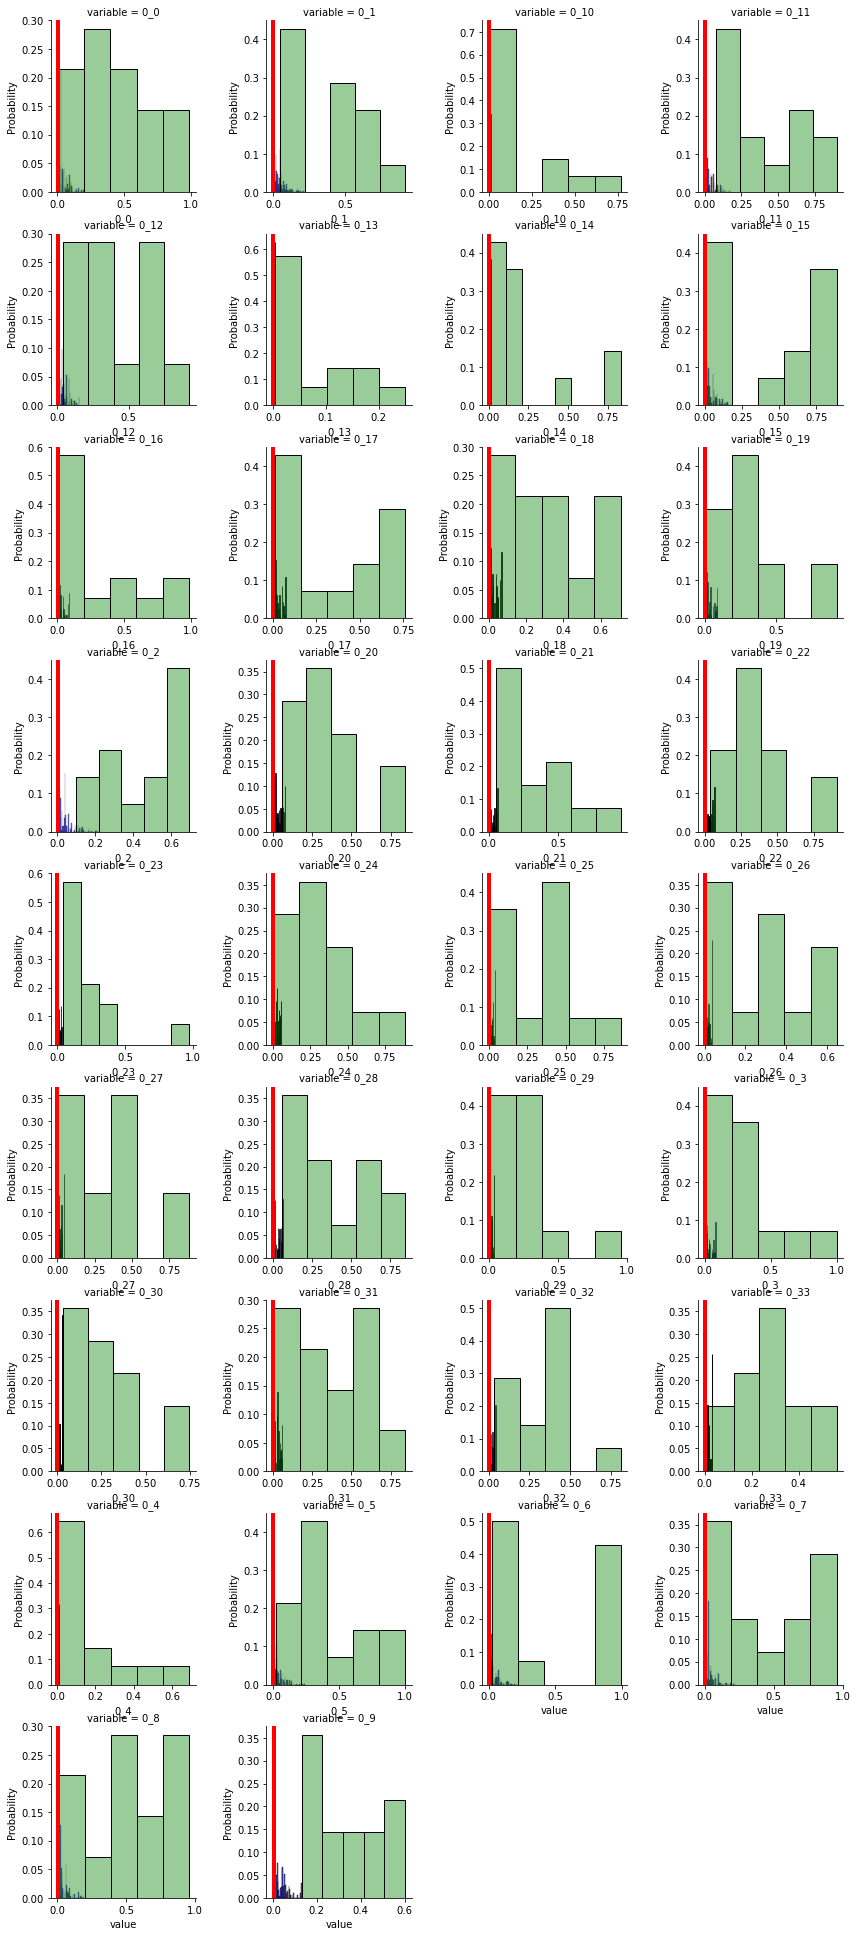

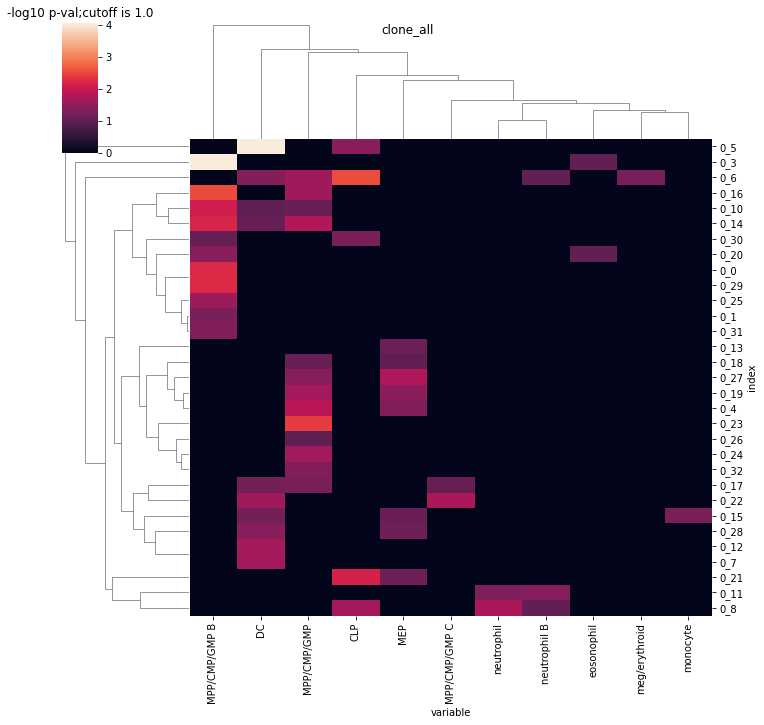

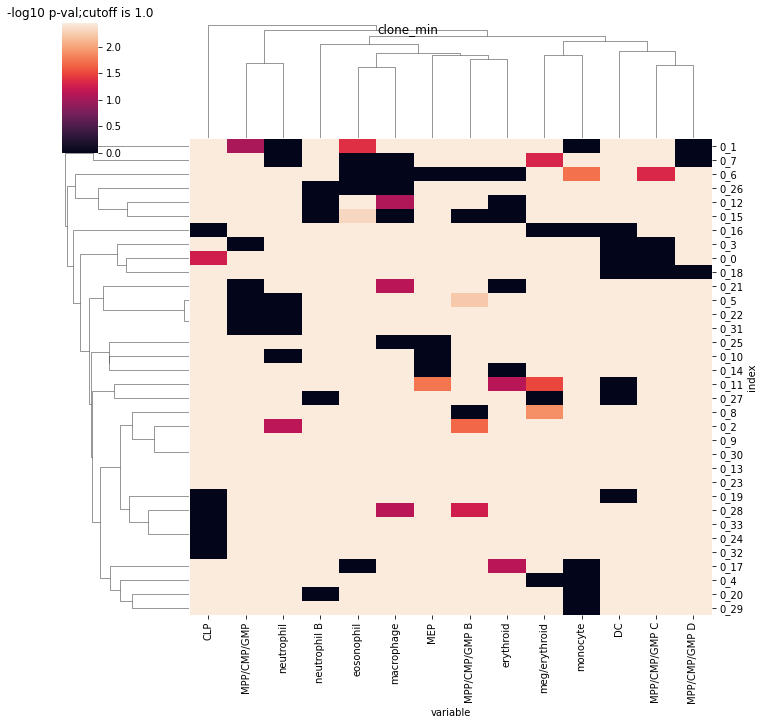

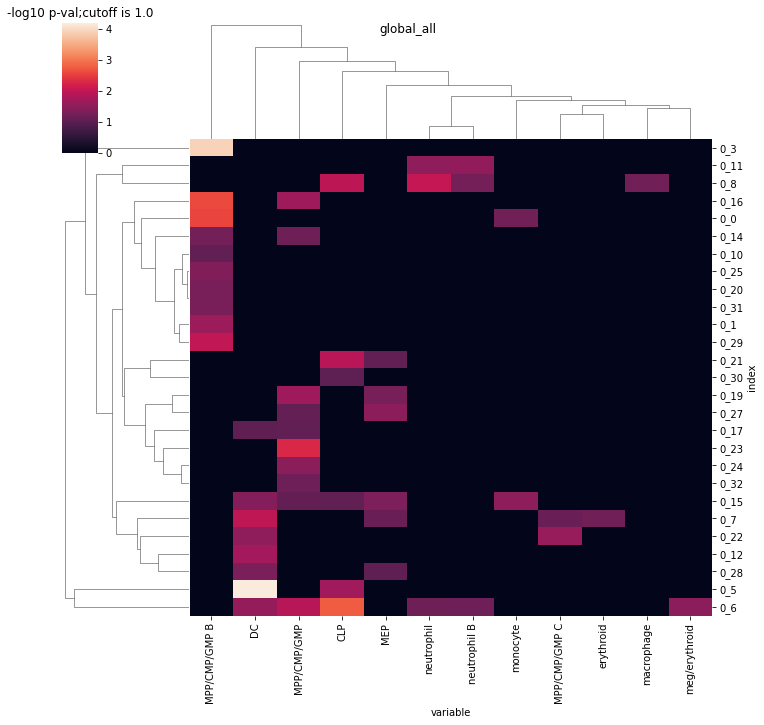

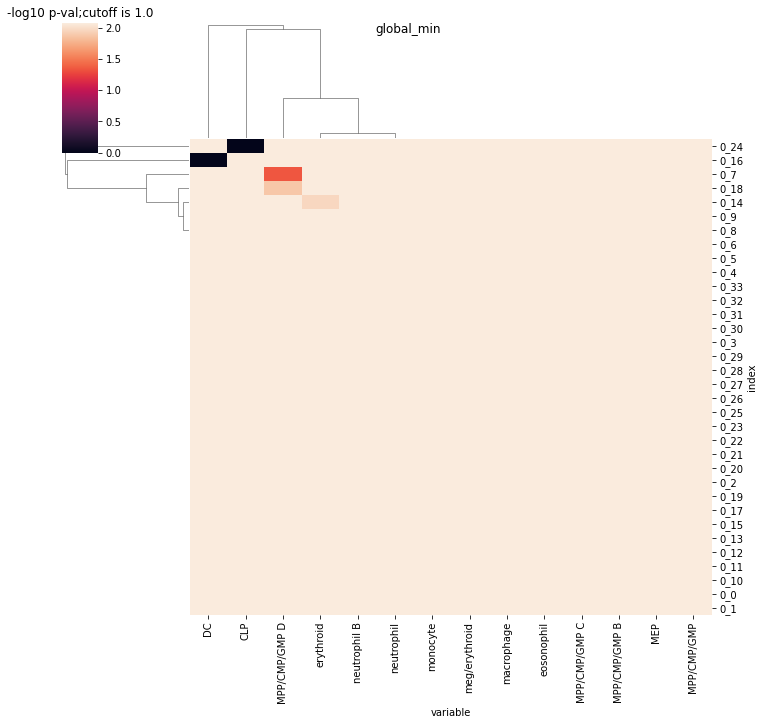

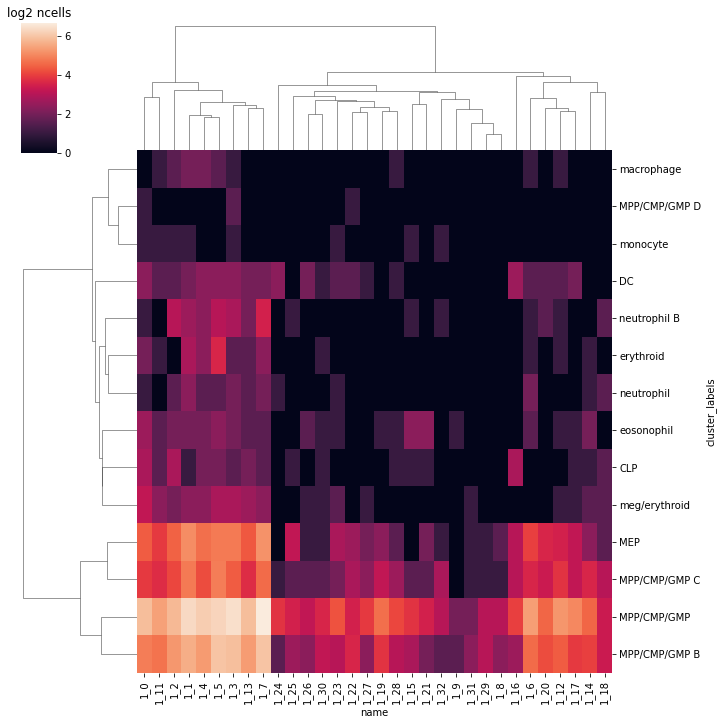

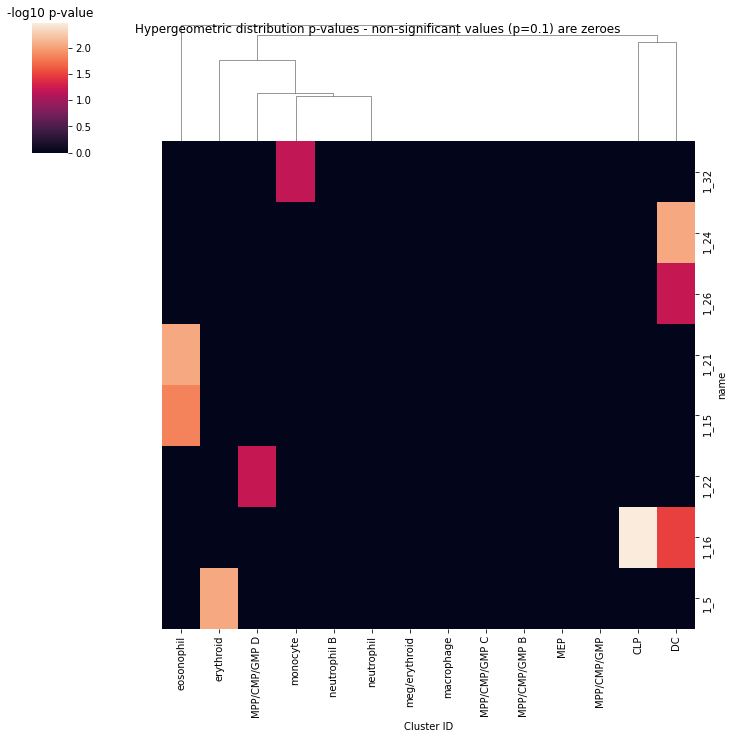

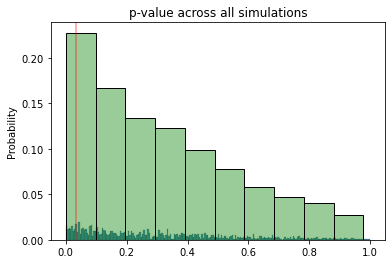

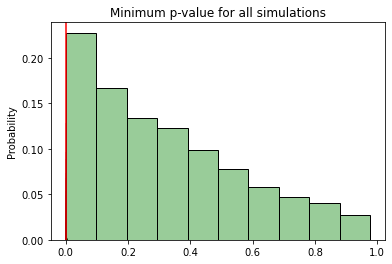

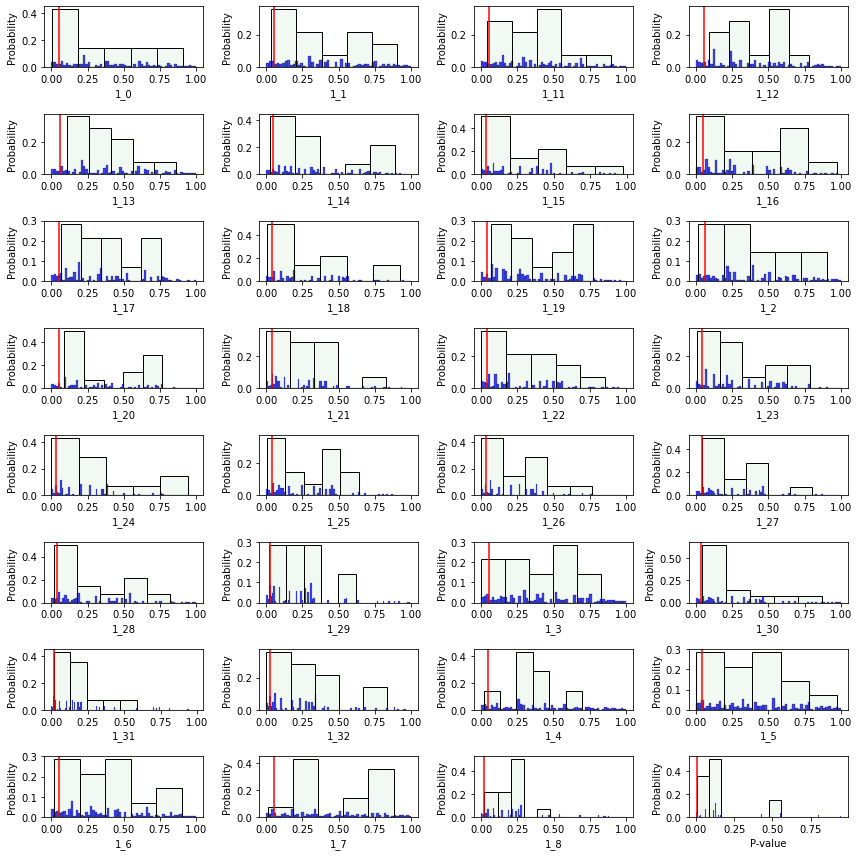

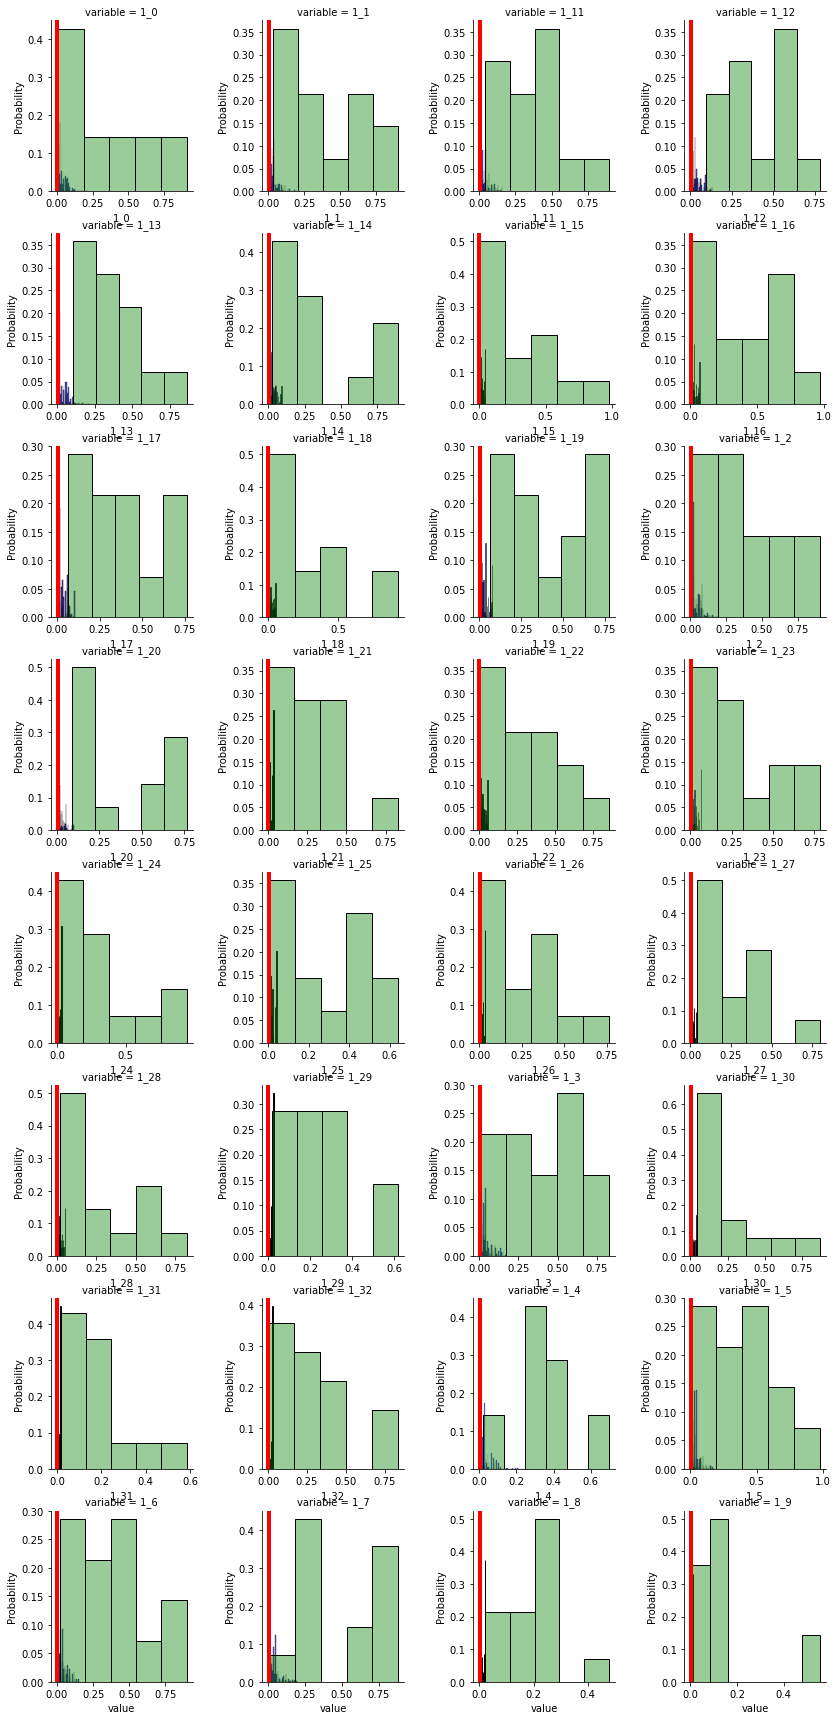

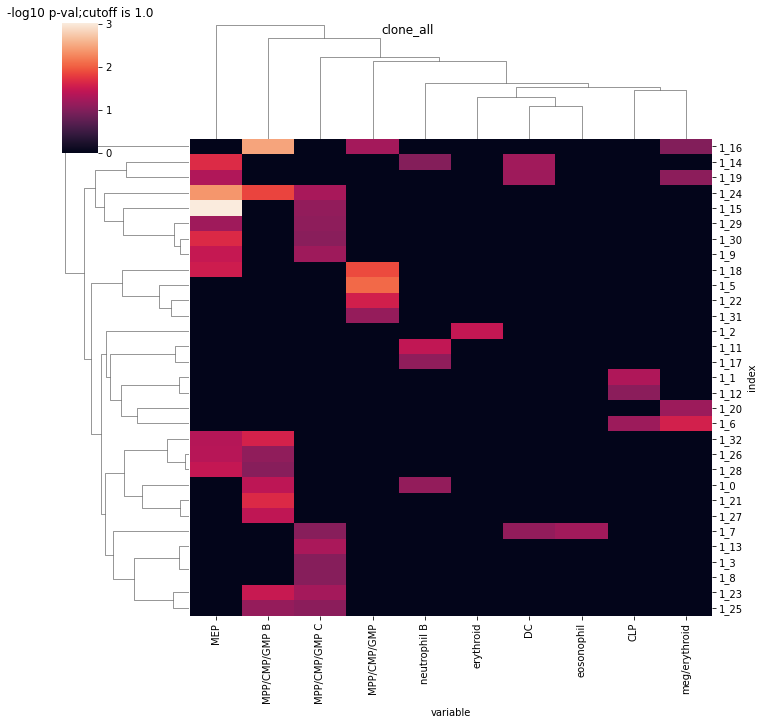

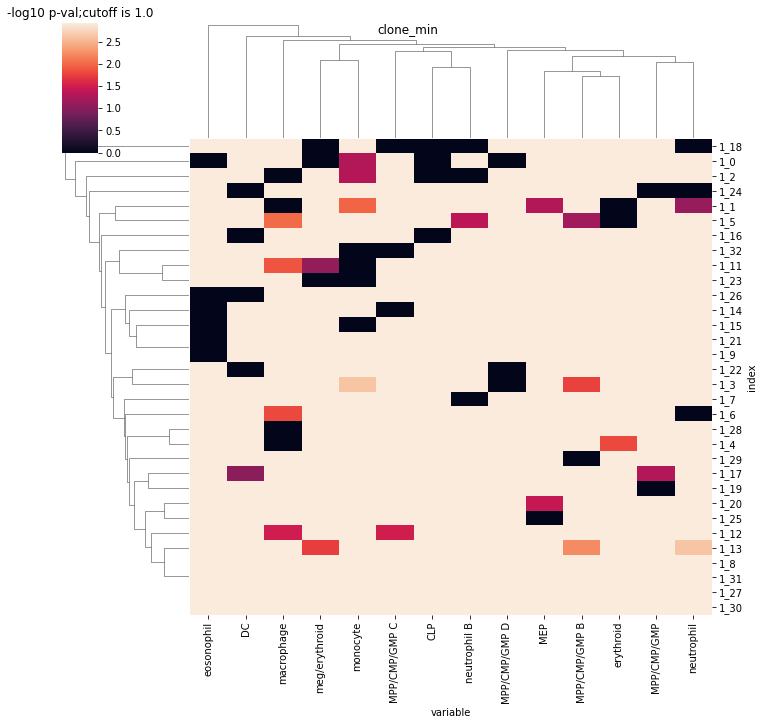

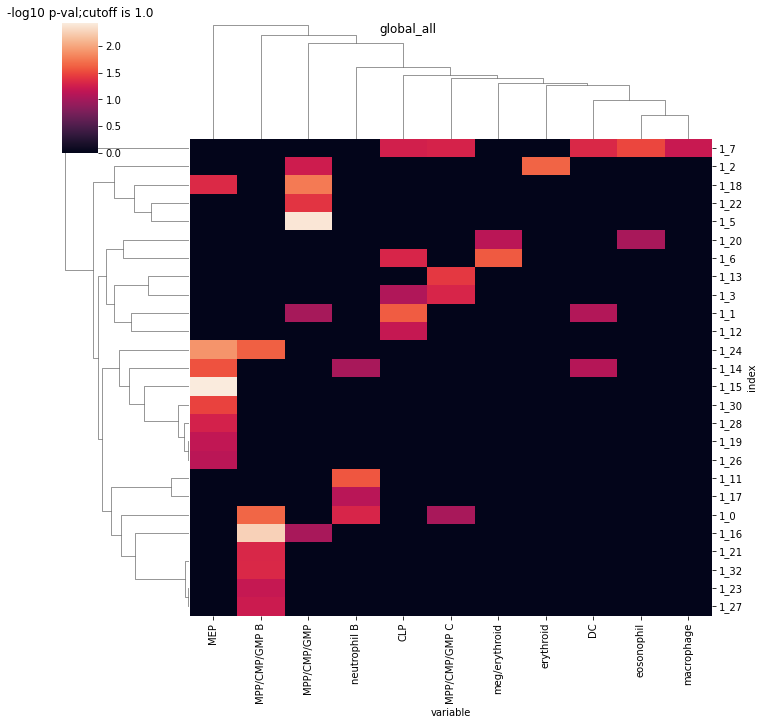

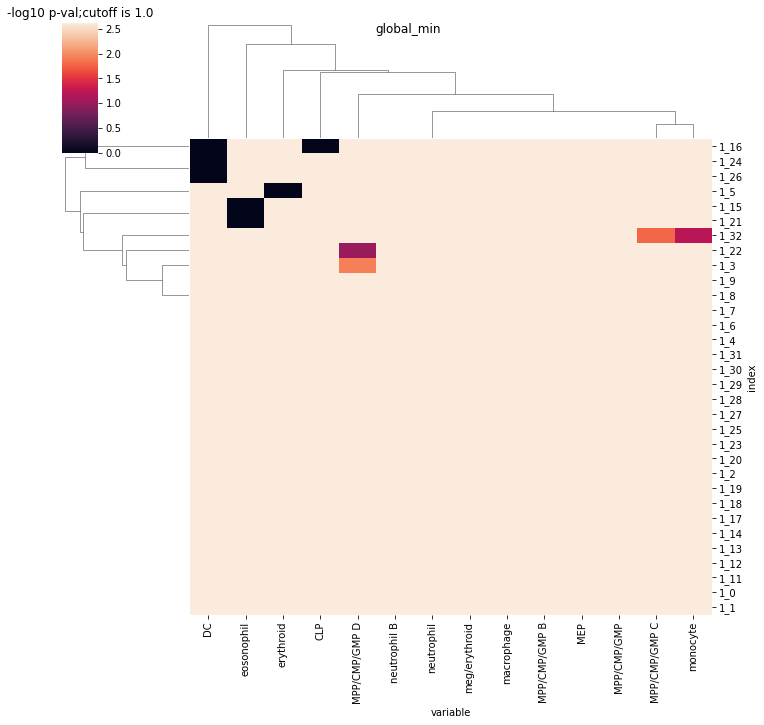

In [7]:
for d, val in cells_meta.groupby("donor"):
    print('donor', d)
    curr_groups = val.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
    curr_groups
    curr_sizes = val.groupby(clone_col).size().sort_values(ascending=False)
    curr_name_cond_size = val.groupby([clone_col]).size()
    curr_name_cond_size = curr_name_cond_size[curr_name_cond_size>min_clone_size]
    curr_clones_filt = curr_name_cond_size.index 
    curr_sizes = curr_sizes.loc[curr_clones_filt].sort_values(ascending=False)
    
    curr_clones = np.unique(curr_groups[clone_col])
    curr_clone_map = {x:ind for ind,x in enumerate(curr_clones)}
    print(curr_clones)
    curr_atac_cl = np.unique(curr_groups[atac_col])
    print(curr_atac_cl)

    curr_don_out = donor_out[int(d)]
    
    # Run init hypergeo and the counts data
    cs.hypergeo_plots(curr_groups, curr_clones, curr_atac_cl, curr_sizes, p_thresh, atac_col,
                   clone_col, curr_don_out)
    
    out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(curr_groups, curr_don_out, atac_col, clone_col, p_thresh, curr_clones, 
                                                      curr_atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                                  n_cpus=n_cpus)

#     print("plotting counts")
#     curr_groups["log2_count"] = np.log2(curr_groups["count"]+1)
#     g = sns.clustermap(curr_groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
#     plt.gca().set_title("log2 ncells")
#     plt.savefig(join(curr_don_out, "ncells.png"))
#     curr_groups = curr_groups.drop("log2_count", axis=1)
    
#     output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(curr_groups, curr_clones, curr_atac_cl, curr_sizes,
#                                                              p_thresh=p_thresh, atac_col=atac_col, 
#                                                               clone_col=clone_col)

    
#     bh_enrichment_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted.csv"))
#     output_df.to_csv(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.csv"))
    
#     if output_df.shape[0] == 0:   
#         g = sns.clustermap(-np.log10(bh_enrichment_df.fillna(1)), 
#                        row_cluster=False)
#         g.fig.suptitle("No groups were significant")
#     else:
#         g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                        row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
#     g.fig.suptitle(f"Hypergeometric distribution p-values - non-significant values (p={p_thresh}) are zeroes")
#     plt.savefig(join(curr_don_out, "hypergeo_input_padjusted_sigOnly.png"))
    
#     init_bh_enrichment = cs.create_enrichment(curr_groups, atac_col, clone_col, p_thresh,
#                                               clones=curr_clones, atac_cl=curr_atac_cl)
    
#     shuffle = cs.shuffle_hypergeo(curr_groups, atac_col, clone_col, p_thresh, curr_clones, curr_atac_cl, 
#                                   n_shuffle=n_shuffle, to_parallel=True, n_cpus=n_cpus)

#     results_df, out_d = cs.get_out(shuffle, curr_clones, init_bh_enrichment, p_thresh, 
#                                                           curr_clone_map, atac_col, 
#                                                           outdir=join(curr_don_out, "shuffle"))
    
    


In [ ]:
out_df

In [8]:
results_df.head()

,index,variable,value,method
0,1_0,CLP,0.961899,global_all
1,1_1,CLP,0.025110,global_all
2,1_11,CLP,0.476224,global_all
3,1_12,CLP,0.066121,global_all
4,1_13,CLP,0.511346,global_all


## B) Run using all donors as background

plotting counts
Running hypergeo and saving sig results
Running hypergeo shuffle and saving sig results


ic| len(global_min): 10000
ic| len(clone_min): 61
ic| len(clone_min): 61
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic| len(clone_all[curr_ind]): 140000
ic

Number of groups below p-val significance: 132
Number of groups below p-val significance: 4
clone all
axs 16
bh shape (61, 14)
clone min


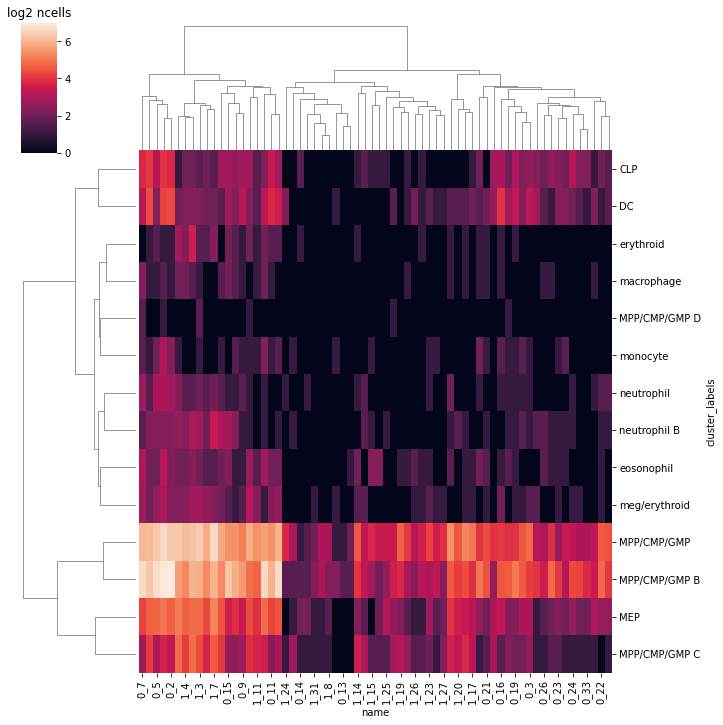

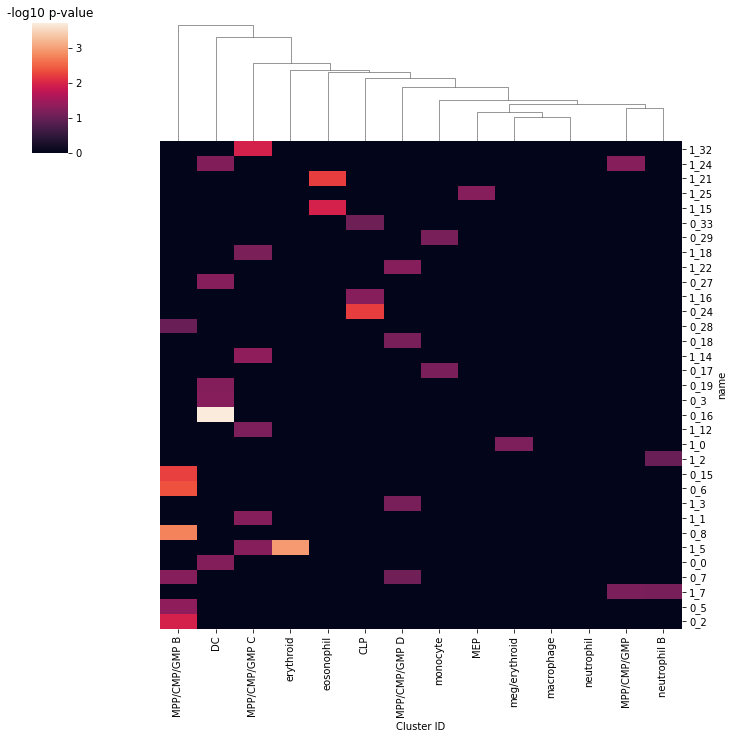

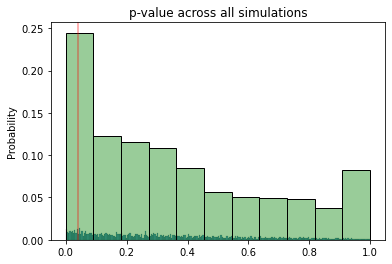

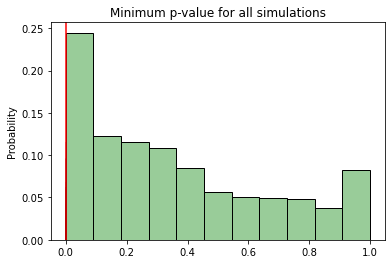

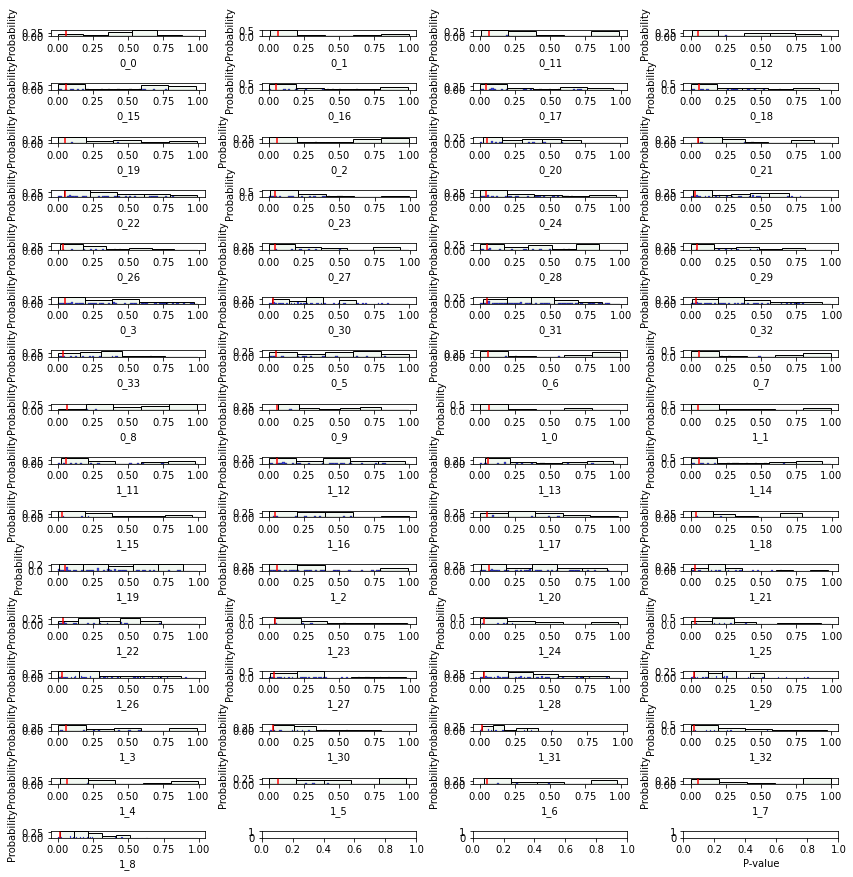

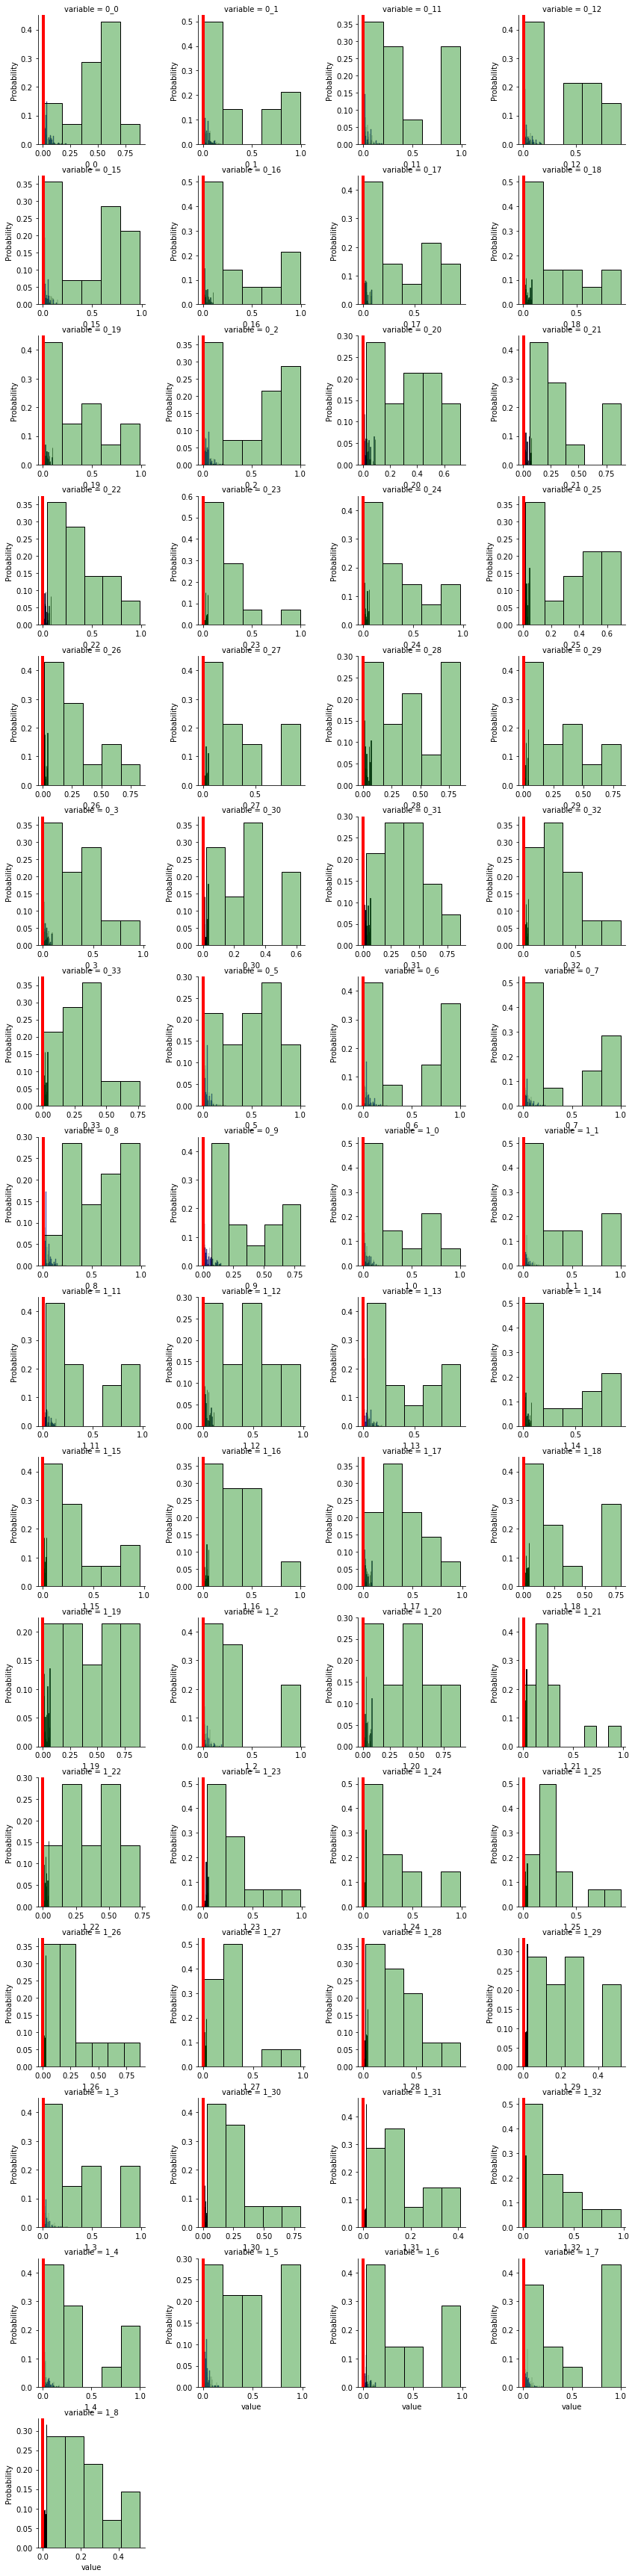

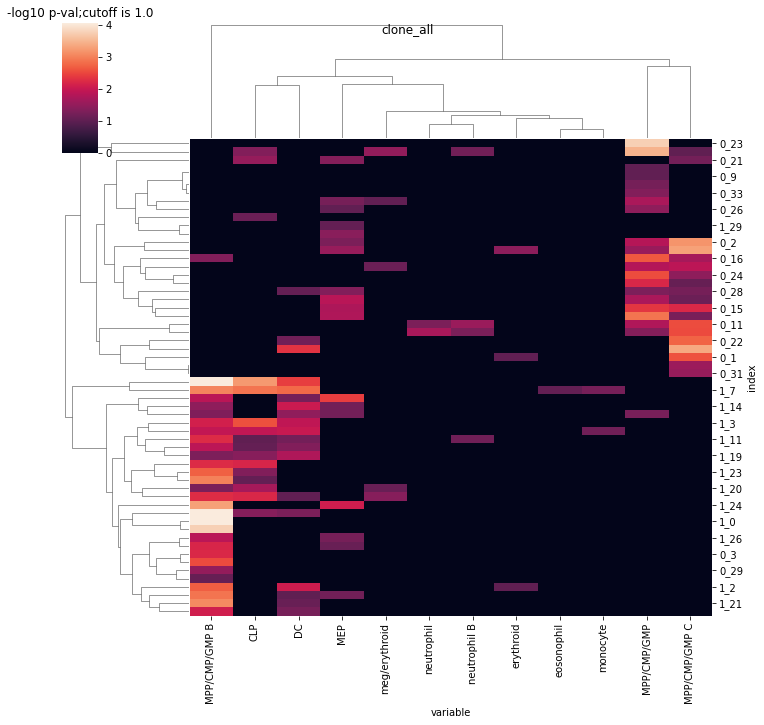

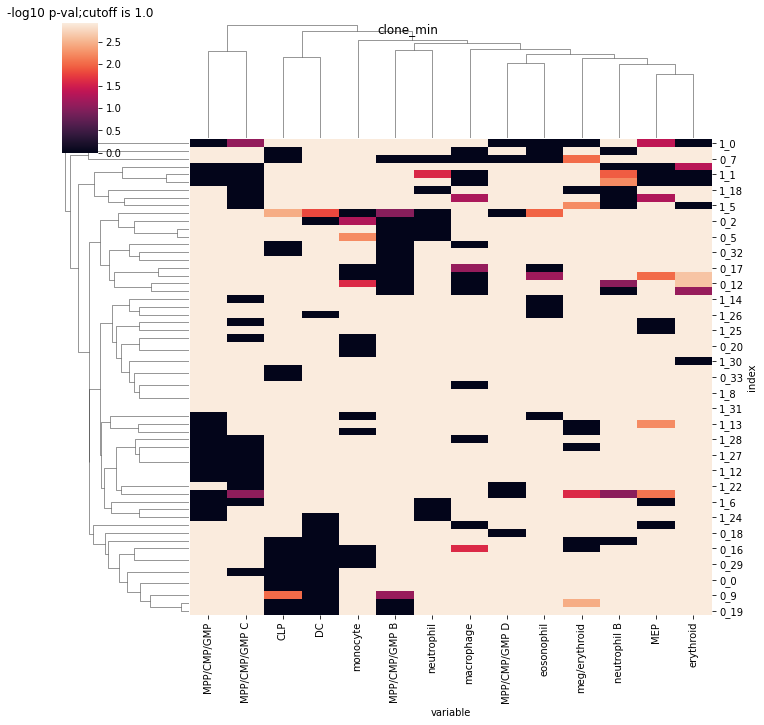

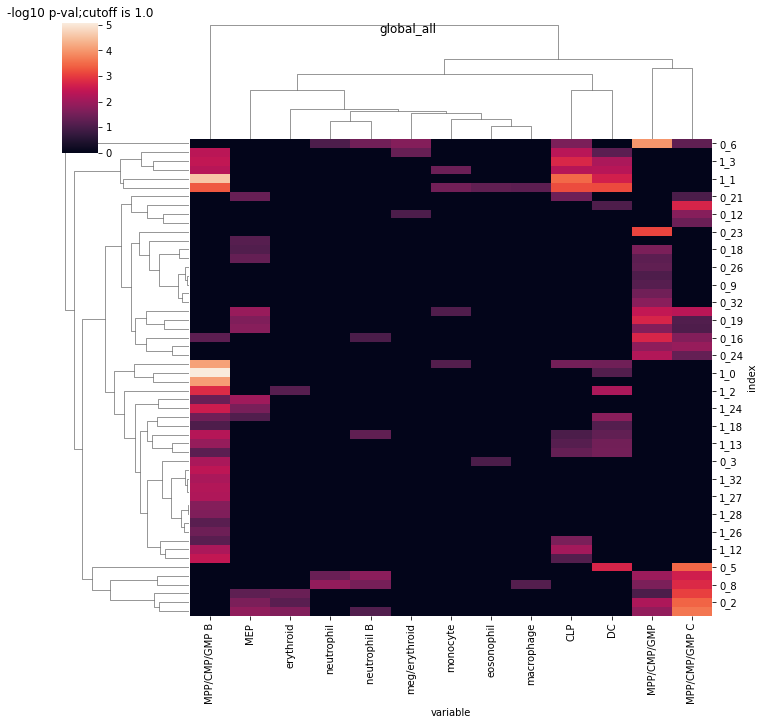

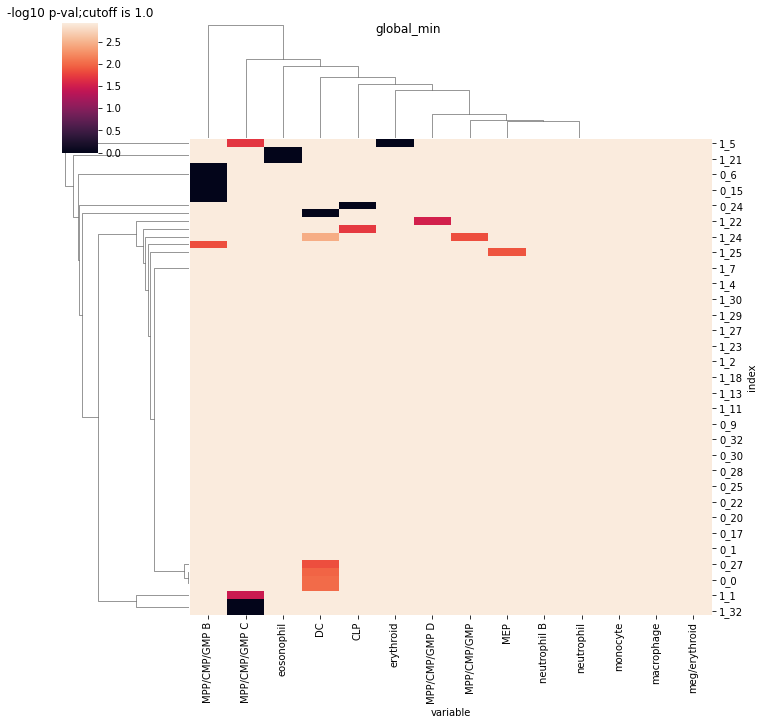

In [9]:
sizes = cells_meta.groupby(clone_col).size().sort_values(ascending=False)
name_cond_size = cells_meta.groupby([clone_col]).size()
name_cond_size = name_cond_size[name_cond_size>min_clone_size]
clones_filt = name_cond_size.index 

sizes = sizes.loc[clones_filt].sort_values(ascending=False)
clones_filt

groups = cells_meta.groupby([atac_col, clone_col]).size().reset_index().rename({0:"count"}, axis=1)
groups

clones = clones_filt.values #np.unique(groups["name"])
clone_map = {x:ind for ind,x in enumerate(clones)}

atac_cl = np.unique(groups[atac_col])
atac_cl


# Run init hypergeo
cs.hypergeo_plots(groups, clones, atac_cl, sizes, p_thresh, atac_col,
               clone_col, all_dir)
## Run shuffle
print("Running hypergeo shuffle and saving sig results")
out_df, hyper_df, results_df, out_d = cs.run_data_and_shuffle(groups, all_dir, atac_col, clone_col, p_thresh, clones, 
                                                  atac_cl, n_shuffle=n_shuffle, figs_close=False, to_p_correct=False,
                                                              n_cpus=n_cpus)

# # plot just the counts
# print("plotting counts")
# groups["log2_count"] = np.log2(groups["count"]+1)
# g = sns.clustermap(groups.pivot(index=atac_col,columns=clone_col, values="log2_count").fillna(0))
# plt.gca().set_title("log2 ncells")
# plt.savefig(join(all_dir, "ncells.png"))


# print("Running hypergeo and saving sig results")
# output_df, bh_enrichment_df = cs.pipeline_groups_hypergeo(groups, clones, atac_cl, sizes,p_thresh, atac_col, clone_col)
# bh_enrichment_df.to_csv(join(all_dir, "hypergeo_padjusted.csv"))
# output_df.to_csv(join(all_dir, "hypergeo_padjusted_sigOnly.csv"))
    
# if output_df.shape[0] == 0:   
#     g = sns.heatmap(-np.log10(bh_enrichment_df.fillna(1)))
#     g.fig.suptitle("No groups were significant")
# else:
#     g = sns.clustermap(-np.log10(bh_enrichment_df.loc[output_df.index].fillna(1)), 
#                    row_cluster=False)
#     g.ax_heatmap.set(xlabel="Cluster ID")
#     g.ax_cbar.set(title="-log10 p-value")
# plt.savefig(join(all_dir, "hypergeo_padjusted_sigOnly.png"))

# init_bh_enrichment = cs.create_enrichment(groups, atac_col, clone_col, p_thresh,
#                                           clones=clones, atac_cl=atac_cl)

# shuffle = cs.shuffle_hypergeo(groups, atac_col, clone_col, p_thresh, clones, atac_cl, n_shuffle=n_shuffle, 
#                               to_parallel=True, n_cpus=24)

# results_df, out_d = cs.get_out(shuffle, clones, init_bh_enrichment_df, p_thresh, clone_map, atac_col, 
#                                                       all_dir=sim_all_dir)

In [10]:
# results_df

# ## Plot shuffle p-value heatmap for each method 

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     sns.clustermap(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1),
#                   vmax=p_thresh+0.1)
#     plt.suptitle(ind)

# ## Same but log10

# for ind, val in results_df[results_df["value"]<p_thresh].groupby("method"):
#     min_m = min(val.loc[val["value"] != 0 , "value"])
#     val.loc[val["value"] == 0 ,"value"] = min_m
    
#     g = sns.clustermap(-np.log10(val.astype(object).pivot(index="index", columns="variable",values="value").fillna(1)))
#     plt.suptitle(ind)
#     g.ax_cbar.set(title=f"-log10 p-val;cutoff is {-np.log10(p_thresh)}")
#     # g.ax_cbar.set(title="-log10 p-value")

    
    

# ## Save significant results_df

# out_df = results_df.rename({"value":"p_value shuffle", "index":"clone", "variable":"lineage"}, axis=1)
# out_df = out_df[out_df["p_value shuffle"]<p_thresh]

# init_p_df = init_bh_enrichment.reset_index().melt(id_vars=["index"]).rename({"variable":"lineage", "index":"clone",
#                                                                           "value": "BH_p_adj"},axis=1).set_index(["clone", "lineage"])
# init_p_df
# #pd.merge(init_p_df, out_df, on=["clone", "lineage"], how="inner" )

# out_df["BH_p_adj"] = out_df.apply(lambda x:init_p_df.loc[(x["clone"],x["lineage"]), "BH_p_adj"], axis=1)
# out_df

# out_df.sort_values(["method", "p_value shuffle", "BH_p_adj"])

# out_df[out_df["BH_p_adj"] != 1]